In [1]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import decode_predictions
from keras.models import Model, load_model
import keras.backend as K

import model as tcav_model
import tcav as tcav
import utils as utils
import activation_generator as act_gen
import tensorflow as tf
import utils_plot as utils_plot


from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from numpy.linalg import norm

import pickle
#from bunch import bunchify

import cav as cav

from os import listdir
from os.path import isfile, join
import operator
from PIL import Image
from keras.preprocessing import image

import os



/data/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
model = None
model = load_model('v3_model.h5')

Instructions for updating:
Colocations handled automatically by placer.


/data/anaconda/envs/py35/lib/python3.5/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
sess = K.get_session()

endpoints_v3 = dict(
    input=model.inputs[0].name,
    input_tensor=model.inputs[0],
    logit=model.outputs[0].name,
    prediction=model.outputs[0].name,
    prediction_tensor=model.outputs[0],
)

tf.logging.set_verbosity(0)

working_dir = '/home/tyler/Desktop/tcav_on_azure'

label_path = os.path.join(working_dir,'labels.txt')

mymodel = tcav_model.KerasModelWrapper(sess, 
        label_path, [299, 299, 3], endpoints_v3, 
        'InceptionV3_public', (-1, 1))

Instructions for updating:
Use tf.cast instead.


In [57]:
#working_dir = '/Users/tyler/Desktop/dissertation/programming/tcav'
working_dir = '/home/tyler/Desktop/tcav_on_azure'

activation_dir =  working_dir + '/activations/'
cav_dir = working_dir + '/cavs/'
source_dir = working_dir + '/concepts/'

target = 'zebra'

concepts = ['striped_sub_2']   

#'mixed0','mixed1', 'mixed2', 'mixed3', 'mixed4', 'mixed5', 'mixed6', 'mixed7', 'mixed8', 'mixed9_0', 'mixed9', 'mixed9_1', 'mixed10'

bottlenecks = ['mixed9']

alphas = [0.1]

In [58]:
act_generator = None
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=50)

tf.logging.set_verbosity(1)

mytcav = tcav.TCAV(sess,
        target, concepts, bottlenecks,
        act_generator, alphas,
        cav_dir = cav_dir,
        num_random_exp=1)

INFO:tensorflow:mixed9 ['striped_sub_2', 'random500_0'] zebra 0.1
INFO:tensorflow:TCAV will 1 params


In [59]:
results = mytcav.run(run_parallel=False)

INFO:tensorflow:running 1 params
INFO:tensorflow:Running param 0 of 1
INFO:tensorflow:running zebra ['striped_sub_2', 'random500_0']
['striped_sub_2', 'random500_0', 'zebra']
INFO:tensorflow:/home/tyler/Desktop/tcav_on_azure/activations/acts_striped_sub_2_mixed9 does not exist, Making one...
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_random500_0_mixed9 shape (50, 8, 8, 2048)
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_zebra_mixed9 shape (50, 8, 8, 2048)
INFO:tensorflow:Training CAV ['striped_sub_2', 'random500_0'] - mixed9 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:using new version
INFO:tensorflow:acc per class {'striped_sub_2': 1.0, 'random500_0': 1.0, 'overall': 1.0}
INFO:tensorflow:/home/tyler/Desktop/tcav_on_azure/cavs/striped_sub_2-random500_0-mixed9-linear-0.1_test.pkl


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


INFO:tensorflow:did save save_path_lin_sep
INFO:tensorflow:Done running 1 params. Took 35.86206007003784 seconds...


## Load CAV

In [60]:
working_dir = '/home/tyler/Desktop/tcav_on_azure'
subpath = 'striped_sub_1-random500_0-mixed9'
cav_path = 'cavs/' + subpath + '-linear-0.1.pkl'
path = os.path.join(working_dir, cav_path)

this_cav = cav.CAV.load_cav(path)

In [61]:
this_cav.concepts

['striped_sub_1', 'random500_0']

## Generate Activations

In [64]:
bottleneck = bottlenecks[0]
target_class = target

acts = act_generator.process_and_load_activations([bottleneck], concepts + [target_class])

act_dotted = acts['striped_sub_2'][bottleneck]
act_zebra = acts['zebra'][bottleneck]

['striped_sub_2', 'zebra']
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_striped_sub_2_mixed9 shape (50, 8, 8, 2048)
INFO:tensorflow:Loaded /home/tyler/Desktop/tcav_on_azure/activations/acts_zebra_mixed9 shape (50, 8, 8, 2048)


In [66]:
len(acts['striped_sub_2']['mixed9'])

50

In [67]:
## cosine sim
import math
def cosine_similarity(v1,v2):
    "compute cosine similarity of v1 to v2: (v1 dot v2)/{||v1||*||v2||)"
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]; y = v2[i]
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    return sumxy/math.sqrt(sumxx*sumyy)

In [68]:
# image list
path = 'activations/images_used_zebra.pkl'
with open(path, 'rb') as f:
    data = pickle.load(f)
    
image_list = data

In [70]:
## make dict
ranked = {}

# define cavs
striped_cav = this_cav.cavs[0]
striped_cav_2d = striped_cav.reshape(-1,1)

#image_list
for count, each in enumerate(image_list):
    
    demo_1 = acts['striped_sub_2']['mixed9'][count]
    demo_2d = demo_1.reshape(-1,1)
    
    cos = cosine_similarity(striped_cav_2d,demo_2d)
    
    ranked[each] = cos

In [71]:
## rank images
sorted_rank = sorted(ranked.items(), key=operator.itemgetter(1),reverse=True)

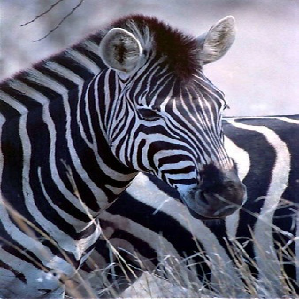

In [74]:
## show image
rank = 49

img_path, cos = sorted_rank[rank]
img = image.load_img(img_path, target_size=(299, 299))
img

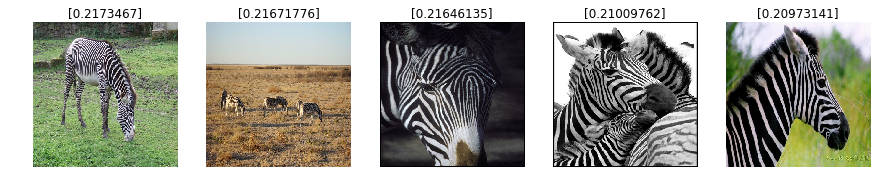

In [80]:
import matplotlib.pyplot as plt

w, h = 120, 120
fig = plt.figure(figsize=(15, 8))
columns, row = 5, 1

start = 10

for i in range(1, columns*rows +1):
    img_path, cos = sorted_rank[start + i]
    img = image.load_img(img_path, target_size=(299, 299))
    fig.add_subplot(rows, columns, i)
    plt.title(cos)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:
mytcav = tcav.TCAV(sess,target, concepts, bottlenecks,
        act_generator, alphas,cav_dir = cav_dir,num_random_exp=1)

In [ ]:
this_cav.get_key()

In [ ]:
deriv = mytcav.get_directional_dir(
mymodel,
'zebra',
'striped_sub_1',
this_cav,
act_zebra
)

In [ ]:
len(deriv)

In [ ]:
this_d = {}

idx = 0
for d in deriv:
    this_d[idx] = d
    idx += 1

sorted_d = sorted(this_d.items(), key=operator.itemgetter(1),reverse=True)

In [ ]:
#source_dir = '/Users/tyler/Desktop/dissertation/programming/tcav/cavs/'
path = 'files/f_used_10.pkl'
with open(path, 'rb') as f:
    data = pickle.load(f)
    
image_list = data

In [ ]:
#this_d

In [ ]:
len(sorted_d)

In [ ]:
rank = 23

img_path = image_list[sorted_d[rank][0]]
img = image.load_img(img_path, target_size=(299, 299))

In [ ]:
img

In [ ]:
#sorted_d

In [ ]:
xx = 2
top = images[sorted_d[0][0]]
bottom = images[sorted_d[xx][0]]
this_img = bottom
#this_img = top

In [ ]:
this_img

In [ ]:
img_path = source_images + this_img
img = image.load_img(img_path, target_size=(299, 299))

In [ ]:
img

## Load filenames

In [ ]:
#image_list

In [ ]:
len(image_list)

In [ ]:
#sorted_d

In [ ]:
xx = 3
bottom = image_list[sorted_d[xx][0]]
this_img = bottom

img_path = this_img
img = image.load_img(img_path, target_size=(299, 299))

img

In [ ]:
class_acts = acts
for i in range(len(class_acts)):
    print(i)
    act = np.expand_dims(class_acts[i], 0)

In [ ]:
working_dir = '/Users/tyler/Desktop/dissertation/programming/tcav'
activation_dir =  working_dir + '/activations/'
cav_dir = working_dir + '/cavs/'
source_dir = working_dir + '/concepts'

target = 'zebra'
concepts = ['striped'] 
concepts = ['dotted']   

bottlenecks = ['mixed8']


alphas = [0.1]

In [ ]:
activation_dir =  working_dir + '/activations/acts_zebra_mixed9'


with open(activation_dir, 'rb') as f:
    x = np.load(f)
    #data = pickle.load(f)

In [ ]:
x.shape

In [ ]:
#acts

In [ ]:
#images

In [ ]:
source_images

In [ ]:
files = [source_images + i for i in images]
imgs = act_generator.load_images_from_files(files)

In [ ]:
act_zebra.shape

In [ ]:
8 * 8 * 1280

In [ ]:
a = act_dotted[0].reshape(81920)
b = act_zebra[1].reshape(81920)

In [ ]:
cos_sim(a,b)

In [ ]:
cos_sim(dotted_cav,b)

In [ ]:
a = np.ones(4)
b = np.ones(4) * -1
b[3]  = -2

In [ ]:
a

In [ ]:
b

In [ ]:
cos_sim(a,b)

In [ ]:
def cos_sim(a,b):
    return np.dot(a, b)/(norm(a)*norm(b))